James Gardner, 2022 

want to analyse science case/s for CE only:

CE-N 40km with CE-S 40km or 20km

if done, then look at CE-S with one ET detector

In [96]:
from benchmarking import *
from gwbench.basic_relations import f_isco_Msolar

from scipy.stats import gmean
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.cosmology import Planck18
from p_tqdm import p_map

# # suppress warnings
# from warnings import filterwarnings
# filterwarnings('ignore')

### Replicating Borhanian and Sathya 2022 injections and detection rates, then for CE only 

In [2]:
# structure: network, injection loop (inj, benchmark, save data), plot snr histogram, ...
# ... calculate efficiency, calculate detection rate

# try for this network, then CE only (refer to App E for CE discussion), compare to other five in Section 2a?
# --- HLVKI+ ---
network_spec = ['A+_H', 'A+_L', 'V+_V', 'K+_K', 'A+_I']
locs = [x[-1] for x in network_spec]
net = network.Network(network_spec)

# --- BNS ---
# waveform, LAL list: https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group___l_a_l_sim_inspiral__h.html
# wf_model_name = 'lal_bns'
# wf_other_var_dic = dict(approximant='IMRPhenomD_NRTidalv2') # for tidal, see https://arxiv.org/abs/1905.06011
# to-do: fix "TypeError: hfpc() missing 2 required positional arguments: 'lam_t' and 'delta_lam_t'"
# --> calculate tidal parameters from sampled m1, m2 in injections.py? requires Love number and radii (i.e. choose an EoS)
wf_model_name, wf_other_var_dic = 'tf2_tidal', None # to-do: stop using this once tidal params found
net.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic=wf_other_var_dic)
# injection settings - source
mass_dict = dict(dist='gaussian', mean=1.35, sigma=0.15, mmin=1, mmax=2)
spin_dict = dict(geom='cartesian', dim=1, chi_lo=-0.05, chi_hi=0.05)
# zmin, zmax, seed (use same seeds to replicate results)
redshift_bins = ((0, 0.5, 7669), (0.5, 1, 3103), (1, 2, 4431), (2, 4, 5526), (4, 10, 7035), (10, 50, 2785))
coeff_fisco = 4 # fmax = 4*fisco for BNS, 8*fisco for BBH

base_params = {
    'tc':    0,
    'phic':  0,
    'gmst0': 0, # assume zero given B2021
    'lam_t': 800, # combined dimensionless tidal deformability, 800 for GW170817, to-do: figure out
    'delta_lam_t': 0, # assuming zero but can be calculated if m1, m2, Love number, and EoS (i.e. radii) known
}

# derivative settings
# assign with respect to which parameters to take derivatives for the FIM
deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'
# assign which parameters to convert to log or cos versions for differentiation
conv_cos = ('dec', 'iota')
conv_log = ('Mc', 'DL', 'lam_t')
numerical_deriv_settings = dict(step=1e-9, method='central', order=2, n=1) # default

# network settings: whether to include Earth's rotation and individual detector calculations
use_rot = 1
only_net = 1

# injection settings - other: number of injections per redshift bin (over 6 bins)
num_injs = 100 # start with 10, then build to 1e6 (how did they compute 1e6 with numerical derivs?)
redshifted = 1 # whether sample masses already redshifted wrt z
if wf_other_var_dic is not None:
    file_tag = f'NET_{net.label}_WF_{wf_model_name}_{wf_other_var_dic["approximant"]}_NUM-INJS_{num_injs}'
    human_file_tag = f'network: {net.label.replace("..", ", ")}\nwaveform: {wf_model_name} with {wf_other_var_dic["approximant"]}\nnumber of injections per bin: {num_injs}'
else:
    file_tag = f'NET_{net.label}_WF_{wf_model_name}_NUM-INJS_{num_injs}'
    human_file_tag = f'network: {net.label.replace("..", ", ")}\nwaveform: {wf_model_name}\nnumber of injections per bin: {num_injs}'    
    
# if tf2 or tf2_tidal used
generate_symbolic_derivatives(wf_model_name, wf_other_var_dic, deriv_symbs_string, locs, use_rot)

All lambdified derivatives already exist.


Generate results, skip this cell if previously generated

In [ ]:
# injection and benchmarking
# concatenate injection data from different bins
inj_data = np.empty((len(redshift_bins)*num_injs, 14))
for i, (zmin, zmax, seed) in enumerate(redshift_bins):
    cosmo_dict = dict(sampler='uniform', zmin=zmin, zmax=zmax)
    # transposed array to get [[Mc0, eta0, ..., z0], [Mc1, eta1, ..., z1], ...]
    # [Mc, eta, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, DL, iota, ra, dec, psi, z]    
    inj_data[i*num_injs:(i+1)*num_injs] = np.array(injections.injections_CBC_params_redshift(cosmo_dict, mass_dict, spin_dict, redshifted, num_injs=num_injs, seed=seed)).transpose()

def calculate_benchmark_from_injection(inj):
    """given a 14-array of [Mc, eta, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, DL, iota, ra, dec, psi, z],
    returns a 7-tuple of the
    * redshift z,
    * integrated snr,
    * fractional Mc and DL and absolute eta and iota errors,
    * 90% sky area.
    sigma_log(Mc) = sigma_Mc/Mc is fractional error in Mc and similarly for DL, sigma_eta is absolute,
    while |sigma_cos(iota)| = |sigma_iota*sin(iota)| --> error in iota requires rescaling from output"""
    varied_keys = ['Mc', 'eta', 'chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'DL', 'iota', 'ra', 'dec', 'psi', 'z']
    varied_params = dict(zip(varied_keys, inj))
    z = varied_params.pop('z')
    Mc, eta, iota = varied_params['Mc'], varied_params['eta'], varied_params['iota']
    
    Mtot = Mc/eta**0.6
    #fisco = (6**1.5*PI*Mtot)**-1 # missing some number of Msun, c=1, G=1 factors
    fisco = f_isco_Msolar(Mtot) #4.4/Mtot*1e3 # Hz # from https://arxiv.org/pdf/2011.05145.pdf
    fmin, fmax, df = 5., float(min(coeff_fisco*fisco, 1024)), 10 # df=1/16 (fine) 
    f = np.arange(fmin, fmax, df)

    # net_copy is automatically deleted once out of scope (is copying necessary with Pool()?)
    net_copy = deepcopy(net)
    inj_params = dict(**base_params, **varied_params)
    net_copy.set_net_vars(f=f, inj_params=inj_params, deriv_symbs_string=deriv_symbs_string,
                          conv_cos=conv_cos, conv_log=conv_log, use_rot=use_rot)

    basic_network_benchmarking(net_copy, numerical_over_symbolic_derivs=False, only_net=only_net,
                               numerical_deriv_settings=numerical_deriv_settings, hide_prints=True)

    if net_copy.wc_fisher:
        # convert sigma_cos(iota) into sigma_iota
        abs_err_iota = abs(net_copy.errs['cos_iota']/np.sin(iota))
        return (z, net_copy.snr, net_copy.errs['log_Mc'], net_copy.errs['log_DL'], net_copy.errs['eta'],
                abs_err_iota, net_copy.errs['sky_area_90'])
    else:
        # to-do: check if CE only is still ill-conditioned
        return (z, *np.full(6, np.nan))
    
# calculate results: z, snr, errs (logMc, logDL, eta, iota), sky area
# p_umap is unordered in redshift for greater speed (check)
results = np.array(p_umap(calculate_benchmark_from_injection, inj_data, num_cpus=os.cpu_count()-1))
# filter out NaNs
results = without_rows_w_nan(results)
if len(results) == 0:
    print('All values are NaN, FIM is ill-conditioned.')
np.save(f'data_B&S2022_replication/results_{file_tag}.npy', results)

Run from here to load and plot results

Calculting efficiency and plotting

In [93]:
results = np.load(f'data_B&S2022_replication/results_{file_tag}.npy')

# count efficiency over sources in (z, z+Delta_z) for z=0.01 to 50
zmin_plot, zmax_plot, num_zbins_fine = 1e-2, 50, 40 # eyeballing 40 bins from Fig 2
redshift_bins_fine = list(zip(np.geomspace(zmin_plot, zmax_plot, num_zbins_fine)[:-1],
                              np.geomspace(zmin_plot, zmax_plot, num_zbins_fine)[1:])) # redshift_bins are too wide
zavg_efflo_effhi = np.empty((len(redshift_bins_fine), 3))
for i, (zmin, zmax) in enumerate(redshift_bins_fine):
    z_snr_in_bin = results[:,0:2][np.logical_and(zmin < results[:,0], results[:,0] < zmax)]
    if len(z_snr_in_bin) == 0:
        zavg_efflo_effhi[i] = [np.nan, np.nan, np.nan]
    else:
        zavg_efflo_effhi[i,0] = gmean(z_snr_in_bin[:,0]) # geometric mean, just using zmax is cleaner but less accurate
        zavg_efflo_effhi[i,1] = np.mean(z_snr_in_bin[:,1] > SNR_THRESHOLD_LO)
        zavg_efflo_effhi[i,2] = np.mean(z_snr_in_bin[:,1] > SNR_THRESHOLD_HI)
zavg_efflo_effhi = without_rows_w_nan(zavg_efflo_effhi)    

# fit three-parameter sigmoids to efficiency curves vs redshift
sigmoid_3parameter = lambda z, a, b, c : ((1+b)/(1+b*np.exp(a*z)))**c
# from Table 9
p0s = [[62.08, 0.00584, 0.3341], [607.7, 0.006674, 0.3529]] # threshold 10 then 100
# use p0=(ai,bi,ci) or bounds=([a0,a1],[b0,b1],[c0,c1])
popts, pcovs = zip(curve_fit(sigmoid_3parameter, zavg_efflo_effhi[:,0], zavg_efflo_effhi[:,1], method='dogbox', p0=p0s[0]),
                   curve_fit(sigmoid_3parameter, zavg_efflo_effhi[:,0], zavg_efflo_effhi[:,2], method='dogbox', p0=p0s[1]))
perrs = [np.sqrt(np.diag(pcov)) for pcov in pcovs]
# lambdas in list comprehension are unintuitive, be explicit unless confident, see:
# https://stackoverflow.com/questions/6076270/lambda-function-in-list-comprehensions
# det_eff_fits = [(lambda z : sigmoid_3parameter(z, *popt)) for popt in popts]
det_eff_fits = [(lambda z : sigmoid_3parameter(z, *popts[0])), (lambda z : sigmoid_3parameter(z, *popts[1]))]
# print(f'input {p0}\noptimal {list(popt)}\nerrors {perr}')

# detection efficiency, interpolate from sigmoid fit
def det_eff(z, snr_threshold):
    if snr_threshold == 10:
        return det_eff_fits[0](z)
    elif snr_threshold == 100:
        return det_eff_fits[1](z)
    else:
        # to-do: add this feature
        raise ValueError("SNR thresholds other than 10 or 100 are not yet supported") 

# to-do: fix merger rate so that the plot reaches beyond 1e5 detections per year, maybe a units issue?
#merger_rate = lambda z: injections.bns_md_merger_rate(z) # too low (1e1) but below is too large (1e13)
# don't know if injections.bns_md_merger_rate(z) is R(z) or \dot{n}(z) (merger rate density)
# bns_md_merger_rate_uniform_comoving_volume_redshift_inversion_sampler suggests the latter
differential_comoving_volume = lambda z : 4.*PI*Planck18.differential_comoving_volume(z).value # in Mpc^3
merger_rate = lambda z: injections.bns_md_merger_rate(z)*differential_comoving_volume(z) # now in yr^-1? what is bns_md..._rate in?
# not just 1e-9 difference, confusing

# i.e. "merger rate" in Fig 2, not R(z) but int R(z)/(1+z), i.e. if perfect efficiency, quad returns (value, error)
det_rate_limit = lambda z0 : quad(lambda z : merger_rate(z)/(1+z), 0, z0)[0]
# detection rate
det_rate = lambda z0, snr_threshold : quad(lambda z : det_eff(z, snr_threshold)*merger_rate(z)/(1+z), 0, z0)[0]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

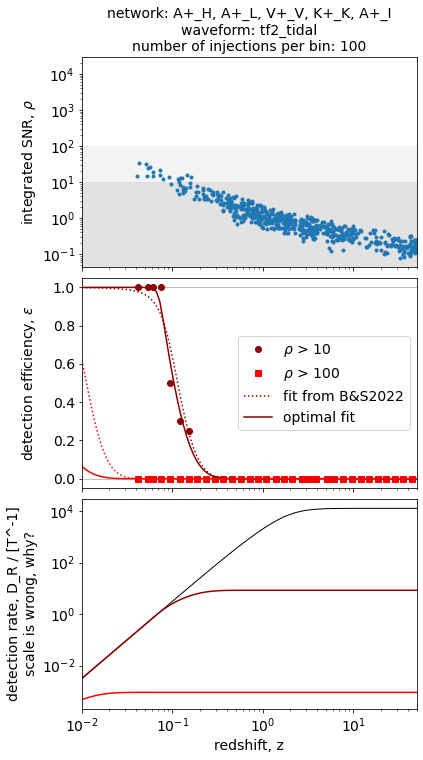

In [97]:
# plotting
colours = 'darkred', 'red'
zaxis_plot = np.geomspace(zmin_plot, zmax_plot, 100)

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 12), gridspec_kw={'wspace':0, 'hspace':0.05})

# SNR vs redshift
# use integrated SNR rho from standard benchmarking, not sure if B&S2022 use matched filter
axs[0].loglog(results[:,0], results[:,1], '.')
axs[0].axhspan(0, SNR_THRESHOLD_LO, alpha=0.5, color='lightgrey')
axs[0].axhspan(0, SNR_THRESHOLD_HI, alpha=0.25, color='lightgrey')
axs[0].set_ylabel(r'integrated SNR, $\rho$')
axs[0].set_title(human_file_tag, fontsize=14)

# efficiency vs redshift
axs[1].axhline(0, color='grey', linewidth=0.5)
axs[1].axhline(1, color='grey', linewidth=0.5)
axs[1].plot(zavg_efflo_effhi[:,0], zavg_efflo_effhi[:,1], 'o', color=colours[0], label=fr'$\rho$ > {SNR_THRESHOLD_LO}')
axs[1].plot(zavg_efflo_effhi[:,0], zavg_efflo_effhi[:,2], 's', color=colours[1], label=fr'$\rho$ > {SNR_THRESHOLD_HI}')
axs[1].semilogx(zaxis_plot, list(p_map(lambda z : sigmoid_3parameter(z, *p0s[0]),   zaxis_plot)), color=colours[0], linestyle='dotted', label='fit from B&S2022')
axs[1].semilogx(zaxis_plot, det_eff_fits[0](zaxis_plot), color=colours[0], label='optimal fit')
axs[1].semilogx(zaxis_plot, list(p_map(lambda z : sigmoid_3parameter(z, *p0s[1]),   zaxis_plot)), color=colours[1], linestyle='dotted')
axs[1].semilogx(zaxis_plot, det_eff_fits[1](zaxis_plot), color=colours[1])
axs[1].legend()
axs[1].set_ylim((0-0.05, 1+0.05))
axs[1].set_ylabel(r'detection efficiency, $\varepsilon$')
fig.align_ylabels()

# detection rate vs redshift
# merger rate depends on star formation rate and the delay between formation and merger
axs[2].loglog(zaxis_plot, list(p_map(det_rate_limit, zaxis_plot)), color='black', linewidth=1)
axs[2].loglog(zaxis_plot, list(p_map(lambda z : det_rate(z, snr_threshold=10), zaxis_plot)), color=colours[0])
axs[2].loglog(zaxis_plot, list(p_map(lambda z : det_rate(z, snr_threshold=100), zaxis_plot)), color=colours[1])
# axs[2].set_ylabel(r'detection rate, $D_R$ / $\mathrm{yr}^{-1}$')
axs[2].set_ylabel('detection rate, D_R / [T^-1]\nscale is wrong, why?')

axs[-1].set_xscale('log')
axs[-1].set_xlim((zmin_plot, zmax_plot))
axs[-1].xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=0.1*np.arange(1, 10), numticks=10))
axs[-1].xaxis.set_minor_formatter(plt.NullFormatter())
axs[-1].set_xlabel('redshift, z')

fig.savefig(f'snr_eff_rate_vs_redshift_{file_tag}.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)

In [ ]:
# to-do: fix merger rate units so that the plot reaches beyond 1e5 detections per year, maybe a units issue?

In [ ]:
# to-do: increase sampling below 4e-2, but App A uses (0, 0.5, seed)?

In [ ]:
# to-do: re-factor and try other five networks and CE alone

In [ ]:
# to-do: study BBH science case as well

In [ ]:
"""In fact, we see that the three generations (A+, Voyager, and NG) are qualitatively different
with respect to every metric used in this study."""